# Scoring
Separating this out just so I can run multiple things at once.

In [134]:
import pickle
import itertools
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms


In [135]:
resdir = "res"
datadir = "data"
htmldir = f"{resdir}/html"
res_folder = 'kcap25'
tasks = ["re-docred", "re-docshred"]
models = ["bert-large-cased", "roberta-large"]
data_split = "dev_c"

## Scoring
This section will introduce some scoring metrics!
We don't really have information on the domain/range just yet, so it's going to be very simple metrics.

In [136]:
# The input scores look like this, where P17 is the variable relation label.
# scores = {'relu': {'max': {'P17': {'hsd': [...]}}}}
# The output scores need to instead look like this:
# scores = {'relu': {'max': {'hsd': {'top_5': 0.0}}}}
# Easy enough.


def score_fixer(subscores, doc, rel, flipsort=False, dr=False, task_name='docred'):
    """
    No, we're not cheating here. By "fixing" the scores, we're actually trying to make things more fair.
    We want to try and present only one candidate per entity pair, but we generate candidates at the
    mention level, which can greatly inflate the number of true (and false) statements.
    So, this function filters the candidates by the highest-scoring version.
    It also filters candidates by domain and range restrictions, in case that didn't happen earlier.
    """
    seen = set()
    res_scores = []
    list_sort = list(sorted(subscores, key=lambda x:x[-1]) if flipsort else sorted(subscores, key=lambda x:-x[-1]))
    # print(list_sort)
    count_true = 0
    count_false = 0
    first_true = -1
    i = 0
    for score in list_sort:
        ex = score[0:2]
        # If we've seen this pair before, then it had a higher score, so skip it.
        # We include the tag because there are some documents which have the same mentions marked for multiple
        # entities, so the pairs could simultaneously be correct and incorrect... it's weird.
        if ex not in seen:
            if dr:
                # Check the domain and range calculated elsewhere to make sure this should be kept.
                if ex in dr[doc][rel]:
                    if score[2]:
                        count_true += 1
                        if first_true == -1:
                            first_true = i
                    else:
                        count_false += 1
                    seen.add(ex)
                    res_scores.append(score)
                    i += 1
            else:
                if score[2]:
                    count_true += 1
                    first_true = min(first_true, i)
                else:
                    count_false += 1
                seen.add(ex)
                res_scores.append(score)
                i += 1
    return res_scores, first_true, count_true, count_false, i


def counts_to_percent(fullscores):
    rel_len = {}
    for rel in fullscores:
        if rel != 'total_docs':
            for nlpl in fullscores[rel]:
                for tk in fullscores[rel][nlpl]:
                    for scr in fullscores[rel][nlpl][tk]:
                        if rel not in rel_len:
                            rel_len[rel] = fullscores[rel][nlpl][tk][scr]['total_docs']
                        if fullscores[rel][nlpl][tk][scr]['total_docs'] > 0:
                            if 'ratioB' == tk:
                                fullscores[rel][nlpl][tk][scr] = (fullscores[rel][nlpl]['#true'][scr]['correct'] / fullscores[rel][nlpl]['#false'][scr]['correct'])*100.0
                            elif '#' not in tk:
                                fullscores[rel][nlpl][tk][scr] = (fullscores[rel][nlpl][tk][scr]['correct'] / fullscores[rel][nlpl][tk][scr]['total_docs'])*100.0
                            else:
                                fullscores[rel][nlpl][tk][scr] = (fullscores[rel][nlpl][tk][scr]['correct'] / fullscores[rel][nlpl][tk][scr]['total_docs'])
                        else:
                            fullscores[rel][nlpl][tk][scr] = -1
    return fullscores, rel_len


def top_k(folder, task_name, data_set, all_models, max_blanks, max_passes, compare_folder=None, max_k=10, num_blanks=0, dr=None, max_doc=1000, n_passes=1, model_name="bert-large-cased"):
    compare_folder = compare_folder or folder
    compare_pth = f"{resdir}/{compare_folder}"#/{model_name}"
    out_scores = {'total_docs':0}
    pth = f"{resdir}/{folder}"#/{model_name}"
    # print(pth)
    if os.path.exists(pth):
        # print("Exists.")
        for d in range(max_doc):
            # pth = f"{resdir}/20240614/{(task_name + '_') if task_name != 're-docred' else ''}{(model_name + '_')
            # if model_name != 'bert-large-cased' else ''}{data_set}_{d}{'_' + str(num_blanks) + 'blanks' if num_blanks != 2 else ''}_MASK{'' if n_passes == 1 else '_'+str(n_passes)}.pickle"
            pickle_file = f"{pth}/{task_name}_{model_name}_{data_set}_{d}_{num_blanks}b_{n_passes}p.pickle"
            # print(pickle_file)
            if os.path.exists(pickle_file):
                # print("Exists.")
                if task_name == "biored": # and model_name != "bert-large-cased":
                    pth2 = f"{pth}/{task_name}_bert-large-cased_{data_set}_{d}_0b_{n_passes}p.pickle"
                    if not os.path.exists(pth2):
                        # print(f"But not {pth2}")
                        continue
                # else:
                #     all_docs_tested = True
                #     for _m in all_models:
                #         for _b in range(max_blanks):
                #             for _p in range(max_passes):
                #                 if _b == 0 or _p > 0:
                #                     all_docs_tested = all_docs_tested and os.path.exists(f"{compare_pth}/{task_name}_{_m}_{data_set}_{d}_{_b}b_{_p}p.pickle")
                #     if not all_docs_tested:
                #         continue


                with open(pickle_file, "rb") as pfile:
                    out_scores['total_docs'] += 1
                    # print(pth)
                    try:
                        in_scores = pickle.load(pfile)
                    except:
                        in_scores = None
                    if in_scores: # In case there are no relations at all.
                        for nl in in_scores:
                            # if nl not in ["top50"]:
                            #     continue
                            # if nl not in out_scores:
                            #     out_scores[nl] = {}
                            for pl in in_scores[nl]:
                                nlpl = f"{nl}"
                                for rel in in_scores[nl][pl]:
                                    if rel not in out_scores:
                                        out_scores[rel] = {}    
                                    if nlpl not in out_scores[rel]:
                                        out_scores[rel][nlpl] = {}
                                    for scr in in_scores[nl][pl][rel]:
                                        sf, best, nt, nf, tot = score_fixer(in_scores[nl][pl][rel][scr], flipsort=(scr=="msd"), dr=dr, doc=d, rel=rel, task_name=task_name)
                                        # There are some documents where all correct answers get filtered out due to the domain and range constraints.
                                        # In this sense, the document does not represent the relation as defined by the schema/ontology, so we choose
                                        # to filter it out anyway.
                                        # The other conditions try to avoid "easy mode" documents which only inflate the scores.
                                        if best == -1 or tot < 10 or nf < 5:
                                            continue
                                        # tks = [f"top_{k}" for k in range(1, max_k+1)]
                                        tks = [f"top_{k}" for k in [1, 2, 3, 5, 10] if k <= max_k]

                                        for tk in ["ratioB", "mrr"] + tks + ["ratioA", "#true", "#false"]:
                                            if tk not in out_scores[rel][nlpl]:
                                                out_scores[rel][nlpl][tk] = {}
                                            if scr not in out_scores[rel][nlpl][tk]:
                                                out_scores[rel][nlpl][tk][scr] = {}
                                                out_scores[rel][nlpl][tk][scr]['total_docs'] = 1
                                                out_scores[rel][nlpl][tk][scr]['correct'] = 0
                                            else:
                                                out_scores[rel][nlpl][tk][scr]['total_docs'] += 1
                                        # best = trues.index(True)
                                        out_scores[rel][nlpl]["mrr"][scr]['correct'] += 1/(best + 1) if best != -1 else 0
                                        # Because, of course, there are some documents with *only* correct answers.
                                        if nf > 0:
                                            out_scores[rel][nlpl]["ratioA"][scr]['correct'] += nt/nf
                                        else:
                                            out_scores[rel][nlpl]["ratioA"][scr]['total_docs'] -= 1
                                        out_scores[rel][nlpl]["#true"][scr]['correct'] += nt
                                        out_scores[rel][nlpl]["#false"][scr]['correct'] += nf
                                        if best > -1 and best < max_k:
                                            for k in range(best, max_k):
                                                if k in [0, 1, 2, 4, 9]:  # k+1 in [1, 2, 3, 5, 10]
                                                    out_scores[rel][nlpl][f"top_{k+1}"][scr]['correct'] += 1
                                    
    return out_scores

# Now you are here: Just need to make sure that you don't count a point off if there were no relations of that type to be extracted from the document to begin with.

# results = top_k()
# results

In [137]:
import json

rel_info = dict()

for task in tasks:
    with open(f'{datadir}/{task}/rel_info_full.json', 'r') as rel_info_file:
        rel_info[task] = json.load(rel_info_file)

import pickle



In [138]:
if 'biored' in rel_info:
    rel_info['biored']['Association']['name']

In [139]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import time
import tqdm
from collections import defaultdict

from IPython.display import display

flipsort = False
max_doc = 1001



cm = sns.light_palette("green", as_cmap=True)

def inner_work(folder, task_name, data_set, max_doc, all_models, max_blanks, max_passes, num_blanks, n_passes, dr, model_name, compare_folder=None):
    res, lens = counts_to_percent(top_k(all_models=all_models, max_blanks=max_blanks, max_passes=max_passes, folder=folder, task_name=task_name, data_set=data_set, dr=dr, num_blanks=num_blanks, max_doc=max_doc, n_passes=n_passes, model_name=model_name, compare_folder=compare_folder))
    output = {}
    # print(f"{res['total_docs']=}")
    if res['total_docs'] > 0:
        # output.append(f"D&R restrictions are {'ON' if dr else 'OFF'}.</h1><br/>")
        # print(res.keys())
        rels = sorted((k for k in res.keys() if k != 'total_docs'), key=lambda x: int(x.split(' ')[0][1:])) if (task_name == 'docred' or task_name == 'docshred' or task_name == 're-docred' or task_name == 're-docshred') else sorted(res.keys())
        for rel in rels:
            if rel == 'total_docs':
                continue
            # For the results for a particular relation (e.g., P17)
            rr = res[rel]
            # print(rr.keys())
            # rr2 = {(outerKey, innerKey): values for outerKey, innerDict in rr.items() for innerKey, values in innerDict.items()}

            f_key = list(rr.keys())[0]
            if len(rr[f_key]) == 0:
                continue

            # ratioB = rr[f_key]['ratioB']['pll']
            # nTrue = rr[f_key]['#true']['pll']
            # nFalse = rr[f_key]['#false']['pll']

            add_in_later = "(ratio: {ratioB:.2f}, avg #true: {nTrue:.2f}, avg #false: {nFalse:.2f})"

            rr3 = {(f"{n_passes} Passes", k): {(f"{num_blanks} Blanks", "Metric", k2): v[k2]['pll'] for k2 in v if k2 not in ["ratioA", "ratioB", "#true", "#false"]} for k,v in rr.items()}
            df = pd.DataFrame(rr3).astype('float').transpose()
            # display(df.transpose())
            # assert False
            #   .format_index(str.upper, axis=1) \
            #   .relabel_index(["row 1", "row 2"], axis=0)
            # print(rr)
            # print(rel)
            # print(lens)
            output[rel] = (df, lens[rel])
    else:
        print("Empty.")
    return output, res['total_docs']

# t = tqdm.tqdm(total=(2*2*2*2*1*1*3))
res_map = {}

with open('dev_answers_domain_range.pickle', 'rb') as domain_range_pickle:
    dr_restricted_docred = pickle.load(domain_range_pickle)
    
with open('dev_answers_domain_range_biored.pickle', 'rb') as domain_range_pickle:
    dr_restricted_biored = pickle.load(domain_range_pickle)

with open('re-docred_dev_c_answers_domain_range.pickle', 'rb') as domain_range_pickle:
    dr_restricted_redocred = pickle.load(domain_range_pickle)

with open('re-docshred_dev_c_answers_domain_range.pickle', 'rb') as domain_range_pickle:
    dr_restricted_redocshred = pickle.load(domain_range_pickle)


# res_folder = 'roberta_test'
# comp_folder = 'final'
comp_folder = res_folder
# "distilbert-base-cased", 
# all_models = ["MedBERT", "bert-base-cased", "bert-large-cased", "BiomedNLP-PubMedBERT-large-uncased-abstract", "biobert-large-cased-v1.1", "roberta-large"]
all_models = models
# all_models = ["roberta-large"]
max_blanks = 2
max_passes = 2

while True:
    # t.reset()
    aggregated = {}
    for task_name, dr in [("re-docred", dr_restricted_redocred), ("re-docshred", dr_restricted_redocshred)]: # ("biored", dr_restricted_biored),  # ("docred", dr_restricted_docred), ("docshred", dr_restricted_docred), 
        for data_set in ["dev_c"]: # ["dev", "train"]:
            for model in all_models:
                aggregated[model] = {}
                aggregated[model]["printable"] = False
                for num_blanks in range(0, max_blanks + 1):  # range(0, 5):
                    aggregated[model][num_blanks] = {}
                    for num_passes in range(0, max_passes + 1):  # range(0, 5):
                    # aggregated[task_name][data_set][num_passes] = {}
                        now = datetime.now()
                        op, t_len = inner_work(res_folder, all_models=all_models, max_blanks=max_blanks, max_passes=max_passes, compare_folder=comp_folder, task_name=task_name, data_set=data_set, max_doc=max_doc, num_blanks=num_blanks, n_passes=num_passes, dr=dr, model_name=model)
                        # print(f"{len(op)=}")
                        if len(op) > 0:
                            k = (task_name, data_set, model, num_blanks) 
                            if k not in res_map:
                                res_map[k] = dict()
                            res_map[k][num_passes] = (op, t_len)
                            filename = f"index_{model}.html" if task_name == "docred" else f"{task_name}.html"
                            with open(f'{htmldir}/{filename}', 'w', encoding='utf8') as resfile:
                                resfile.write(f'<!DOCTYPE html><html><head><title>Experimental Results</title><meta http-equiv="refresh" content="180"/></head><body>')
                                resfile.write(f'<h0>Last updated: {now}</h0>')
                                for res in res_map:
                                    if res[0] == task_name:
                                        # df = pd.concat([d[0][0] for d in res_map[res].values()])
                                        res_by_passes = res_map[res]
                                        df_by_rel = defaultdict(list)
                                        for npass, (ress, t_docs) in res_by_passes.items():
                                            # print(ress)
                                            for rel, dfv in ress.items():
                                                df_by_rel[rel].append((npass,dfv))

                                        resfile.writelines([f"<h1>{task_name.upper()} {data_set.upper()} Test: {model} {'MASK' if True else 'Blanked Entities'}, {res[3]} blanks<br/>First {min(t_docs, max_doc)} docs.<br/>"])
                                        # df: pd.DataFrame
                                        for rel, dfv in df_by_rel.items():
                                            r_len = dfv[0][1][1]
                                            df = pd.concat([v[1][0] for v in sorted(dfv)])
                                            s = df.style
                                            s.background_gradient(cmap=cm, vmin=0.0, vmax=100.0)
                                            s.highlight_max(props="outline: solid black; color: blue;")
                                            s.format('{:.1f}')
                                            s.map(lambda x: 'color: transparent' if pd.isnull(x) else '')

                                            for idx, group_df in df.groupby(level=0):
                                                s.set_table_styles({group_df.index[-1]: [{'selector': '', 'props': 'border-bottom: 2px solid black;'}]}, 
                                                                overwrite=False, axis=1)
                                            # if (task_name, data_set, model, 1, num_blanks, fs) in res_map:
                                            #     pd.concat(df, res)
                                            lines = [f'<h2>{rel} ({rel_info[task_name][rel]["name"]}) after {r_len} docs</h2><br/>',
                                                    s.to_html(),
                                                    '<br/>',
                                                    ]
                                            resfile.writelines(lines)
                                            aggregated[model][num_blanks][rel] = df
                                resfile.write("</body></html>")
                                resfile.flush()
                            # ! scp $htmldir/$filename riley@reyncke.dev:~/public_html >> /dev/null
                            aggregated[model]["printable"] = True
                # print(f"Printable? {aggregated[model]['printable']}")
                if aggregated[model]["printable"]:
                    filename = f"{htmldir}/{task_name}_{model}_agg.html"
                    with open(filename, 'w', encoding='utf8') as resfile:
                        resfile.write(f'<!DOCTYPE html><html><head><title>Experimental Results</title><meta http-equiv="refresh" content="180"/></head><body>')
                        resfile.write(f'<h0>Last updated: {datetime.now()}</h0>')
                        resfile.writelines([f"<h1>{task_name.upper()} {data_set.upper()} Test: {model} {'MASK' if True else 'Blanked Entities'} <br/>First {min(t_docs, max_doc)} docs.<br/>"])
                        _dfs = defaultdict(list)
                        for _nb in aggregated[model]:
                            if _nb != "printable":
                                for rel in aggregated[model][_nb]:
                                    _dfs[rel].append(aggregated[model][_nb][rel])
                        concat_by_rel = {}
                        for rel in _dfs:
                            df = pd.concat(_dfs[rel], axis=1)
                            # df.columns = range(len(df.columns))
                            concat_by_rel[rel] = df
                            s = df.style
                            s.background_gradient(cmap=cm, vmin=0.0, vmax=100.0)
                            s.highlight_max(props="outline: solid black; color: blue;")
                            s.map(lambda x: 'color: white' if pd.isna(x) else '')
                            s.format('{:.1f}', na_rep='-')
                            
                            for idx, group_df in df.groupby(level=0):
                                s.set_table_styles({group_df.index[-1]: [{'selector': '', 'props': 'border-bottom: 2px solid black;'}]}, 
                                                overwrite=False, axis=1)
                            lines = [f'<h2>{rel} ({rel_info[task_name][rel]["name"]}) after {r_len} docs</h2><br/>',
                                                        s.to_html(),
                                                        '<br/>',
                                                        ]
                            resfile.writelines(lines)
                        resfile.write("</body></html>")
                        resfile.flush()
                        with open(f"df_{model}_{task_name}.pickle", 'wb') as df_pickle:
                            pickle.dump(concat_by_rel, df_pickle)
                            print(f"df_{model}_{task_name}.pickle")
                    # if os.path.exists(filename):
                    #     ! scp $filename riley@reyncke.dev:~/public_html >> /dev/null
                # Next thing: Show the DIFFERENCE between DocShRED scores and DocRED scores: Aim for negatives.
    # time.sleep(60)
    break
# t.close()
# df.style
# df

Empty.
Empty.
df_bert-large-cased_re-docred.pickle
Empty.
Empty.
df_roberta-large_re-docred.pickle
Empty.
Empty.
df_bert-large-cased_re-docshred.pickle
Empty.
Empty.
df_roberta-large_re-docshred.pickle


In [140]:
for model in all_models:
    filename = f"{htmldir}/compare_{model}.html"
    with open(filename, 'w') as resfile:
        resfile.write(f'<!DOCTYPE html><html><head><title>Experimental Results</title><meta http-equiv="refresh" content="180"/></head><body>')
        resfile.write(f'<h0>Last updated: {datetime.now()}</h0>')
        resfile.writelines([f"<h1>Re-DocRED vs Re-DocShRED: dev\nTest: {model} {'MASK' if True else 'Blanked Entities'}"])
        with open(f"df_{model}_re-docred.pickle", 'rb') as df_pickle:
            df1 = pickle.load(df_pickle)
        with open(f"df_{model}_re-docshred.pickle", 'rb') as df_pickle:
            df2 = pickle.load(df_pickle)
        for rel in df1:
            df = df2[rel] - df1[rel]
            concat_by_rel[rel] = df
            s = df.style
            s.background_gradient(cmap=sns.light_palette("red", as_cmap=True).reversed(), vmin=-50, vmax=0.0)
            s.highlight_max(props="outline: solid black; color: blue;")
            s.map(lambda x: 'color: white' if pd.isna(x) else '')
            s.format('{:.1f}', na_rep='-')
            
            for idx, group_df in df.groupby(level=0):
                s.set_table_styles({group_df.index[-1]: [{'selector': '', 'props': 'border-bottom: 2px solid black;'}]}, 
                                overwrite=False, axis=1)
            lines = [f'<h2>{rel} ({rel_info[task_name][rel]["name"]}) after {r_len} docs</h2><br/>',
                                        s.to_html(),
                                        '<br/>',
                                        ]
            resfile.writelines(lines)
        resfile.write("</body></html>")
        resfile.flush()
        # ! scp $filename riley@reyncke.dev:~/public_html >> /dev/null




In [141]:
model = "bert-large-cased"
with open(f"df_{model}_re-docred.pickle", 'rb') as df_pickle:
    df1 = pickle.load(df_pickle)
df1

{'P17':                  0 Blanks                                              \
                    Metric                                               
                       mrr      top_1     top_10      top_2      top_3   
 0 Passes None   61.413145  49.930070  87.552448  60.419580  66.433566   
 1 Passes top10  62.232578  48.671329  89.510490  62.797203  70.769231   
 2 Passes top10  62.529473  49.090909  89.790210  62.377622  71.328671   
 
                             1 Blanks                                   \
                               Metric                                    
                     top_5        mrr      top_1     top_10      top_2   
 0 Passes None   74.965035        NaN        NaN        NaN        NaN   
 1 Passes top10  78.181818  50.826918  37.500000  79.722222  49.583333   
 2 Passes top10  79.300699  49.165815  35.833333  77.361111  47.083333   
 
                                        2 Blanks                        \
                           

In [142]:
df.index
df.columns
keep = [('0 Passes', 'None'), ('1 Passes', 'top10'), ('2 Passes', 'top10')]
drop_inds = [i for i in df.index if i not in keep]
df2: pd.DataFrame = df.drop(index=drop_inds,
            columns=[('0 Blanks', 'Metric',  'top_3'), ('1 Blanks', 'Metric',  'top_3'), ('2 Blanks', 'Metric',  'top_3')]
            )

df2.style.format(na_rep='-', precision=2).set_table_styles([{'selector': 'th.col_heading', 'props': 'text-align: left;'}])

In [143]:
df: pd.DataFrame = None
for model in all_models:
    # filename = f"{htmldir}/compare.html"
    # with open(filename, 'w') as resfile:
    #     resfile.write(f'<!DOCTYPE html><html><head><title>Experimental Results</title><meta http-equiv="refresh" content="180"/></head><body>')
    #     resfile.write(f'<h0>Last updated: {datetime.now()}</h0>')
    #     resfile.writelines([f"<h1>DocRED vs DocShRED: dev\nTest: {model} {'MASK' if True else 'Blanked Entities'}"])
    with open(f"df_{model}_re-docred.pickle", 'rb') as df_pickle:
        df1 = pickle.load(df_pickle)
    # with open(f"df_{model}_docshred.pickle", 'rb') as df_pickle:
    #     df2 = pickle.load(df_pickle)
    ct = len(df1)
    for rel in df1:
        if df is not None:
            df += df1[rel]
        else:
            df = df1[rel]
    df /= ct

    keep = [('0 Passes', 'None'), ('1 Passes', 'top10'), ('2 Passes', 'top10')]
    drop_inds = [i for i in df.index if i not in keep]

    df2: pd.DataFrame = df.drop(index=drop_inds, columns=[('0 Blanks', 'Metric',  'top_3'), ('1 Blanks', 'Metric',  'top_3'), ('2 Blanks', 'Metric',  'top_3')])


    # df2.reset_index(drop=False, inplace=True, )

    df2.columns = pd.MultiIndex.from_tuples([(c[0], c[2]) for c in df2.columns])


    s = df2.style.format(na_rep='-', precision=2)
    s.set_table_styles([{'selector': 'th.col_heading', 'props': 'text-align: left;'}])
    s.background_gradient(cmap=sns.light_palette("green", as_cmap=True), vmin=0.0, vmax=100.0)
    # s.map(lambda x: 'color: white' if pd.isna(x) else '')
    for idx, group_df in df2.groupby(level=0):
        s.set_table_styles({group_df.index[-1]: [{'selector': '', 'props': f'border-bottom: 2px solid black;'}]}, 
                        overwrite=False, axis=1)
    # for d in df2.groupby(level=0):
    #     break
    # d[1].style.set_table_styles({d[1].index[-1]: [{'selector': '', 'props': 'border-bottom: 2px solid black;'}]}, overwrite=False, axis=1)
    s.highlight_max(props="text-decoration: underline;", subset=("1 Passes",))
    s.highlight_max(props="text-decoration: underline;", subset=("2 Passes",))
    # s.highlight_max(props="outline: solid black 2px;")
    s.highlight_max(props="font-weight: bold;")
    s.set_caption(f"{model}")
    display(s)

In [144]:
model_names = {
    "bert-large-cased": "BERT Large",
    "roberta-large": "RoBERTa Large",
    "ModernBERT-base": "ModernBERT Base",
    # "distilbert-base-cased": "DistilBERT Base",
}

task_names = {
    "re-docred": "Re-DocRED",
    "re-docshred": "Re-DocShRED",
    # "biored": "BioRED"
}

df: pd.DataFrame = None
keep = [('0 Passes', 'None'), ('1 Passes', 'top10'), ('2 Passes', 'top10')]
dfs = {m:{} for m in model_names}
for model in all_models:
    print("="*50)
    print(model)
    big_oh_boy = []

    for task in ["re-docred", "re-docshred"]:
        with open(f"df_{model}_{task}.pickle", 'rb') as df_pickle:
            df1 = pickle.load(df_pickle)
        # with open(f"df_{model}_docshred.pickle", 'rb') as df_pickle:
        #     df2 = pickle.load(df_pickle)
        ct = len(df1)
        oh_boy = []
        for rel in df1:
            df = df1[rel]
            df2: pd.DataFrame = df.drop(index=[i for i in df.index if i not in keep], columns=[('0 Blanks', 'Metric',  'top_3'), ('1 Blanks', 'Metric',  'top_3'), ('2 Blanks', 'Metric',  'top_3')])

            # df2.reset_index(drop=False, inplace=True, )
            df2.columns = pd.MultiIndex.from_tuples([(rel, c[0], c[2]) for c in df2.columns])

            df_parts = []
            for b in range(3):
                _df = df2[rel, f'{b} Blanks']
                if b > 0:
                    _df = _df.drop(['0 Passes'])
                _df.index = pd.MultiIndex.from_tuples([(i[0][0], f'{b}') for i in _df.index])
                df_parts.append(_df)
            df2 = pd.concat(df_parts)
            # display(df2)
            # break
            # s.background_gradient(cmap=sns.light_palette("green", as_cmap=True), vmin=0.0, vmax=100.0)
            # s.map(lambda x: 'color: white' if pd.isna(x) else '')
            # for idx, group_df in df2.groupby(level=0):
            #     s.set_table_styles({group_df.index[-1]: [{'selector': '', 'props': f'border-bottom: 2px solid black;'}]}, 
            #                     overwrite=False, axis=1)
            # for d in df2.groupby(level=0):
            #     break
            # d[1].style.set_table_styles({d[1].index[-1]: [{'selector': '', 'props': 'border-bottom: 2px solid black;'}]}, overwrite=False, axis=1)
            # s.highlight_max(props="text-decoration: underline;", subset=("1 Passes",))
            # s.highlight_max(props="text-decoration: underline;", subset=("2 Passes",))
            # s.highlight_max(props="outline: solid black 2px;")
            s = df2.style.format(na_rep='-', precision=1)
            s.set_caption(f"{rel}: {rel_info['re-docred'][rel]['name']}")
            # s.set_table_styles([{'selector': 'th.col_heading', 'props': 'text-align: left;'}])
            s.highlight_max(props="font-weight: bold;")
            # display(s)
            oh_boy.append(df2['mrr'])
        df3 = pd.concat(oh_boy, axis=1)
        df3.columns = list(df1.keys())
        big_oh_boy.append(df3)
        s = df3.style.format(na_rep='-', precision=1)

        s.set_caption(f"MRR scores for {model_names[model]} on {task_names[task]}")
        # s.set_table_styles([{'selector': 'th.col_heading', 'props': 'text-align: left;'}])
        s.highlight_max(props="text-decoration: underline;")
        # display(s)
        print(s.to_latex(convert_css=True))
        dfs[model][task] = df3
    df4 = big_oh_boy[1] - big_oh_boy[0]
    s = df4.style.format(na_rep='-', precision=1)

    s.set_caption(f"Difference in MRR scores for {model_names[model]} between DocRED and DocShRED")
    # s.set_table_styles([{'selector': 'th.col_heading', 'props': 'text-align: left;'}])
    s.highlight_max(props="text-decoration: underline;")
    # display(s)
    print(s.to_latex(convert_css=True))


bert-large-cased
\begin{table}
\caption{MRR scores for BERT Large on Re-DocRED}
\begin{tabular}{llrrrrrrrrrr}
 &  & P17 & P27 & P131 & P150 & P161 & P175 & P527 & P569 & P570 & P577 \\
0 & 0 & 61.4 & 39.5 & 67.9 & 27.0 & 52.0 & 39.5 & 16.4 & 43.1 & 39.8 & 30.2 \\
1 & 0 & 62.2 & 48.6 & 73.0 & 21.6 & 45.9 & 49.5 & 10.3 & 55.3 & 52.1 & 36.1 \\
2 & 0 & 62.5 & 48.5 & 72.5 & 21.2 & 53.2 & 51.3 & 10.8 & 51.3 & 51.3 & 30.8 \\
1 & 1 & 50.8 & 56.6 & 62.4 & 23.0 & 50.4 & 55.0 & 12.1 & 44.2 & 36.9 & 39.5 \\
2 & 1 & 49.2 & 53.5 & 61.0 & 28.5 & 37.2 & 49.1 & 8.4 & 32.3 & 38.5 & 41.2 \\
1 & 2 & 44.0 & 46.2 & 54.7 & 20.3 & 50.0 & 49.2 & 11.5 & 29.7 & 30.6 & 41.5 \\
2 & 2 & 47.1 & 45.6 & 56.1 & 22.6 & 45.2 & 52.5 & 9.5 & 30.4 & 31.8 & 35.6 \\
\end{tabular}
\end{table}

\begin{table}
\caption{MRR scores for BERT Large on Re-DocShRED}
\begin{tabular}{llrrrrrrrrrr}
 &  & P17 & P27 & P131 & P150 & P161 & P175 & P527 & P569 & P570 & P577 \\
0 & 0 & 25.7 & 32.5 & 34.7 & 19.1 & 28.6 & 26.5 & 7.2 & 33.1 & 32.9

In [145]:

dfa:pd.DataFrame = dfs['bert-large-cased']['re-docred']
dfb:pd.DataFrame = dfs['bert-large-cased']['re-docshred']

dfa.iloc[0]


P17     61.413145
P27     39.480660
P131    67.904210
P150    26.992422
P161    51.965523
P175    39.483172
P527    16.414681
P569    43.091133
P570    39.788856
P577    30.171596
Name: (0, 0), dtype: float64

In [146]:
# mrers = [11.49,28.66,7.21,9.31,22.38,11.74,2.43,17.83,14.84,21.52]  # For DocRED
mrers = [17.41,32.72,25.85,13.22,27.23,13.17,2.73,18.63,16.77,25.02]  # For Re-DocRED
reddish = "#D55E00FF"
bluish = "#0072B2FF"
greenish = "#009E73FF"

if 'docred' in rel_info:
  rel_info['docred']['P131']['name'] = 'located in the A.T.E.'
  rel_info['docred']['P150']['name'] = 'contains A.T.E.'
if 'docshred' in rel_info:
  rel_info['docshred']['P131']['name'] = 'located in the A.T.E.'
  rel_info['docshred']['P150']['name'] = 'contains A.T.E.'

if 're-docred' in rel_info:
  rel_info['re-docred']['P131']['name'] = 'located in the A.T.E.'
  rel_info['re-docred']['P150']['name'] = 'contains A.T.E.'
if 're-docshred' in rel_info:
  rel_info['re-docshred']['P131']['name'] = 'located in the A.T.E.'
  rel_info['re-docshred']['P150']['name'] = 'contains A.T.E.'

_white = sns.color_palette(["white"]*30, 30)
_black = sns.color_palette(["black"]*30, 30)
_grey = sns.color_palette([(0.75, 0.75, 0.75)]*30, 30)
_transparent = sns.color_palette([(0.0, 0.0, 0.0, 0.0)]*30, 30)

models = [
        #   "distilbert-base-cased",
          "roberta-large",
          "bert-large-cased",
          "ModernBERT-base"
         ]


## Making the figure from the paper

,task,Relation,MRR,model,Experiment
0,re-docred,P17: country\n(L$\cup$M$\cup$O)$\times$L,61.413145,bert-large-cased,BG Knowl.
1,re-docred,P27: country of citizenship\nP$\times$L,39.480660,bert-large-cased,BG Knowl.
2,re-docred,P131: located in the A.T.E.\n(L$\cup$O)$\times$L,67.904210,bert-large-cased,BG Knowl.
3,re-docred,P150: contains A.T.E.\nL$\times$L,26.992422,bert-large-cased,BG Knowl.
4,re-docred,P161: cast member\nM$\times$P,51.965523,bert-large-cased,BG Knowl.
5,re-docred,P175: performer\n(M$\cup$P)$\times$(O$\cup$P),39.483172,bert-large-cased,BG Knowl.
6,re-docred,P527: has part\n(L$\cup$M$\cup$O)$\times$(L$\c...,16.414681,bert-large-cased,BG Knowl.
7,re-docred,P569: date of birth\nP$\times$T,43.091133,bert-large-cased,BG Knowl.
8,re-docred,P570: date of death\nP$\times$T,39.788856,bert-large-cased,BG Knowl.
9,re-docred,P577: publication date\nM$\times$T,30.171596,bert-large-cased,BG Knowl.


,task,Relation,MRR,model,Experiment
0,re-docred,P17: country\n(L$\cup$M$\cup$O)$\times$L,47.734077,roberta-large,BG Knowl.
1,re-docred,P27: country of citizenship\nP$\times$L,40.156961,roberta-large,BG Knowl.
2,re-docred,P131: located in the A.T.E.\n(L$\cup$O)$\times$L,59.735640,roberta-large,BG Knowl.
3,re-docred,P150: contains A.T.E.\nL$\times$L,30.478147,roberta-large,BG Knowl.
4,re-docred,P161: cast member\nM$\times$P,48.509716,roberta-large,BG Knowl.
5,re-docred,P175: performer\n(M$\cup$P)$\times$(O$\cup$P),31.473785,roberta-large,BG Knowl.
6,re-docred,P527: has part\n(L$\cup$M$\cup$O)$\times$(L$\c...,21.942592,roberta-large,BG Knowl.
7,re-docred,P569: date of birth\nP$\times$T,40.601574,roberta-large,BG Knowl.
8,re-docred,P570: date of death\nP$\times$T,37.147438,roberta-large,BG Knowl.
9,re-docred,P577: publication date\nM$\times$T,31.340696,roberta-large,BG Knowl.


[6.4 4.8] 4.0


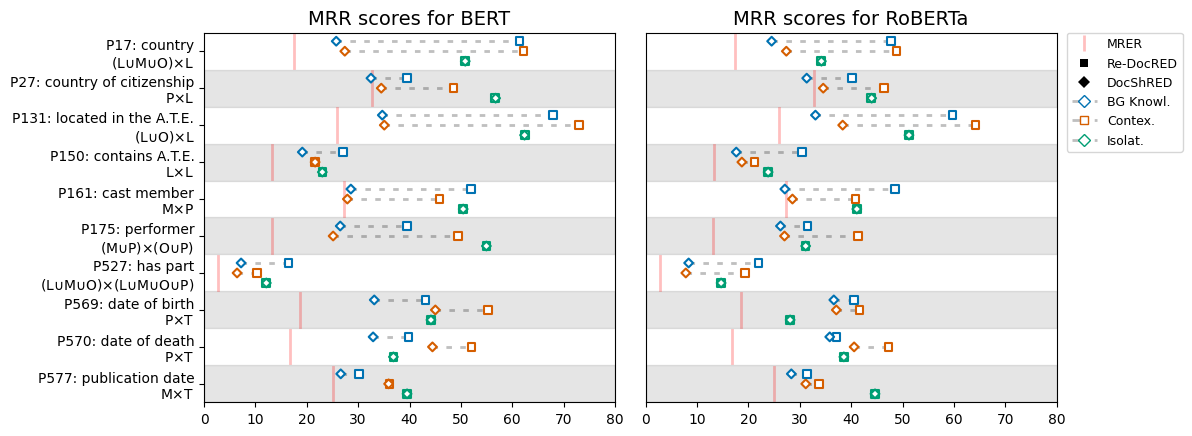

In [174]:
fig, axs = plt.subplots(1, 2)

models = [
          "bert-large-cased",
          "roberta-large",
          "ModernBERT-base",
         ]

model_shortnames = [
    "BERT",
    "RoBERTa",
    "ModernBERT",
]

sym_dr = "s"
sym_ds = "D"

markers = {
    're-docshred': sym_ds,
    're-docred': sym_dr
}

marker_sizes = {
    're-docshred': 20,
    're-docred': 30
}


lgns = []

for x, ax in enumerate(axs):
    m_id = x

    model = models[m_id]

    # experiments = {
    #     0: f"{model_shortnames[m_id]}",
    #     1: f"{model_shortnames[m_id]}+C",
    #     3: f"{model_shortnames[m_id]}+I"
    # }
    experiments = {
        0: f"BG Knowl.",
        1: f"Contex.",
        3: f"Isolat."
    }

    exp_hues = {
        0: bluish,
        1: reddish,
        3: greenish,
    }

    exp_hues_2 = {
        "BG Knowl.": bluish,
        "Contex.": reddish,
        "Isolat.": greenish,
    }

    colors = []

    _task = []
    _relation = []
    _scores = []
    _model = []
    _exps = []

    for i, e in experiments.items():
        dfa:pd.DataFrame = dfs[model]['re-docred']
        dfb:pd.DataFrame = dfs[model]['re-docshred']
        data = dfa.iloc[i]
        data2 = dfb.iloc[i]
        np.stack((data.values, data2.values))

        colors.extend(exp_hues[i] for _ in data.values)

        _task.extend("re-docred" for _ in data.values)
        _task.extend("re-docshred" for _ in data2.values)

        _model.extend(model for _ in data.values)
        _model.extend(model for _ in data2.values)

        _middle = '$\\times$'
        for d in data.index:
            _left  = '$\\cup$'.join(x[0] for x in sorted(rel_info['re-docred'][d]['domain']))
            _right = '$\\cup$'.join(x[0] for x in sorted(rel_info['re-docred'][d]['range']))
            if len(rel_info['re-docred'][d]['domain']) > 1:
                _left = f"({_left})"
            if len(rel_info['re-docred'][d]['range']) > 1:
                _right = f"({_right})"

            _relation.append(f"{d}: {rel_info['re-docred'][d]['name']}\n{_left}{_middle}{_right}")
            # _relation.append(f"{d}: {rel_info['re-docred'][d]['name']}")
        # _relation.extend()
        for d in data2.index:
            _left  = '$\\cup$'.join(x[0] for x in sorted(rel_info['re-docred'][d]['domain']))
            _right = '$\\cup$'.join(x[0] for x in sorted(rel_info['re-docred'][d]['range']))
            if len(rel_info['re-docred'][d]['domain']) > 1:
                _left = f"({_left})"
            if len(rel_info['re-docred'][d]['range']) > 1:
                _right = f"({_right})"
            # _middle = '$\\times$'
            _relation.append(f"{d}: {rel_info['re-docshred'][d]['name']}\n{_left}{_middle}{_right}")
            # _relation.append(f"{d}: {rel_info['re-docshred'][d]['name']}")

        # _relation.extend(f"{d}: {rel_info['re-docshred'][d]['name']}\n{{{'$\\cup$'.join(x[0] for x in rel_info['re-docred'][d]['domain'])}}}$\\times${{{'$\\cup$'.join(x[0] for x in rel_info['re-docred'][d]['range'])}}}" for d in data2.index)

        _scores.extend(data.values)
        _scores.extend(data2.values)

        _exps.extend(e for _ in data.index)
        _exps.extend(e for _ in data2.index)

    pdx = pd.DataFrame.from_dict({"task": _task, "Relation": _relation, "MRR": _scores, "model": _model, "Experiment": _exps})
    display(pdx)
    _hue = pdx[['Relation', "Experiment"]].apply(tuple, axis=1)
    _pal = sns.color_palette(colors, 30)

    exp_hues_2 = {
        "BG Knowl.": _pal[0],
        "Contex.": _pal[10],
        "Isolat.": _pal[20],
    }


    sns.lineplot(
        data=pdx, x='MRR', y='Relation', markers=False, hue=_hue, ax=ax, dashes=(2, 3), linewidth=2, palette=_grey, zorder=1
    )

    line_off = .1


    offset = transforms.ScaledTranslation(0, 0.1, ax.figure.dpi_scale_trans)
    for line in ax.lines[0:10]:
        line.set_transform(line.get_transform() + offset)
    offset = transforms.ScaledTranslation(0, -0.1, ax.figure.dpi_scale_trans)
    for line in ax.lines[20:30]:
        line.set_transform(line.get_transform() + offset)


    # plt.legend([], [], frameon=False)
    off_y_base = -0.0005

    exps = [0, 1, 3]
    # for i, e in enumerate(reversed(exps), start=-1):
    #     offset = transforms.ScaledTranslation(0, off_y_base + .1*i, ax.figure.dpi_scale_trans)
    #     sns.scatterplot(
    #         data=pdx[(pdx['task']=='re-docshred') & (pdx["Experiment"]==experiments[e])], x='MRR', y='Relation', hue=_hue, marker=sym_ds, s=20, ax=ax, palette=_white,zorder=2
    #     )
    #     ax.collections[-1].set_transform(ax.collections[-1].get_transform() + offset)
    #     sns.scatterplot(
    #         data=pdx[(pdx['task']=='re-docred') & (pdx["Experiment"]==experiments[e])], x='MRR', y='Relation', hue=_hue, marker=sym_dr, s=20, ax=ax, palette=_white,zorder=2
    #     )
    #     ax.collections[-1].set_transform(ax.collections[-1].get_transform() + offset)
    for i, e in enumerate(reversed(exps), start=-1):
        offset = transforms.ScaledTranslation(0, off_y_base + .1*i, ax.figure.dpi_scale_trans)
        # print(p_inter['Experiment'])
        # print(p_inter["Experiment"].map(exp_hues_2))

        for ts in ['re-docred', 're-docshred']:
            p_inter = pdx[(pdx['task']==ts) & (pdx["Experiment"]==experiments[e])]
            v = exp_hues_2[p_inter["Experiment"].values[0]]
            sns.scatterplot(
                data=p_inter, x='MRR', y='Relation', hue=_hue, marker=markers[ts], palette=_white, linewidth=1.5, s=marker_sizes[ts], ax=ax, edgecolor=v, zorder=2, 
            )
            ax.collections[-1].set_transform(ax.collections[-1].get_transform() + offset)
        # # print("Cool!")
        # p_inter = pdx[(pdx['task']=='re-docred') & (pdx["Experiment"]==experiments[e])]
        # v = exp_hues_2[p_inter["Experiment"].values[0]]
        # sns.scatterplot(
        #     data=p_inter, x='MRR', y='Relation', hue=_hue, marker=sym_dr, linewidth=2, s=50, ax=ax, palette=_pal, edgecolor=v, zorder=2
        # )
        # ax.collections[-1].set_transform(ax.collections[-1].get_transform() + offset)

    # plt.legend([],[], frameon=False)
    # print(ax.collections)
    # sns.scatterplot(
    #     data=pdx[pdx['task']=='re-docred'], x='MRR', y='Relation', hue=_hue, marker="o", s=50, ax=ax, palette=_pal
    # )
    # plt.legend([],[], frameon=False)
    # print(ax.collections)
    # for i in range(3):
    # offset = transforms.ScaledTranslation(0, .1, ax.figure.dpi_scale_trans)
    # for c in ax.collections[20:30]:
    #     trans = c.get_transform()
    #     c.set_transform(trans + offset)

    ax: plt.Axes
    for i in range(5):
        ax.axhspan(ymin=0.5 + i*2, ymax=1.5 + i*2, color=[0,0,0, 0.1])
    for i, mrer in enumerate(reversed(mrers)):
        ax.axvline(mrer, ymin=0.1*i + 0.005, ymax=0.1*i + 0.095, color=[1.0,0,0, 0.25], zorder=1, lw=2)


    # fig, ax = plt.subplots()

    # x_max = 60 if m_id != 0 else 90

    ax.set(xlim=(0, 80), ylim=(9.5, -0.5))
    ax.set_ylabel("", fontsize=0)
    if x > 0:
        ax.yaxis.set_visible(False)
        ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_title(f"MRR scores for {model_names[model].split()[0]}", fontsize=14)
    ax.get_legend().remove()
    # lgn = plt.legend()
    # lgns.append(lgn)
    # if x == 0:
        # plt.gca().add_artist(lgn)

    width = 347.12354 // 72.27

    factor = 8.0 / 6.4

custom_lines = [
    mpl.lines.Line2D([], [], color=[1.0,0,0, 0.25], marker='|', linestyle='None', linewidth=0, markeredgecolor=[1.0,0,0,0.25], markeredgewidth=2, markersize=12),
]
custom_lines += [
    mpl.lines.Line2D([0], [0], color="w", marker=sym_dr, label='Scatter', linewidth=0, markerfacecolor='black', markeredgewidth=0.0, markersize=6),
    mpl.lines.Line2D([0], [0], color="w", marker=sym_ds, label='Scatter', linewidth=0, markerfacecolor='black', markeredgewidth=0.0, markersize=6),
]
custom_lines += [
    mpl.lines.Line2D([0, 1], [0, 0], color=(0.75, 0.75, 0.75), marker='s' if m == 1 else 'D', label='Scatter', markeredgewidth=1, markerfacecolor='white', markeredgecolor=exp_hues[m], dashes=[4], lw=2, markersize=6)
    for m in exps
]
# print(exps)
custom_labels = ['MRER'] + ['Re-DocRED', 'DocShRED'] + [experiments[m] for m in exps]
# custom_lines[1], custom_lines[2], custom_lines[5], custom_lines[4], custom_lines[3] = custom_lines[5], custom_lines[1], custom_lines[4], custom_lines[2], custom_lines[3]
# custom_labels[1], custom_labels[2], custom_labels[5], custom_labels[4], custom_labels[3] = custom_labels[5], custom_labels[1], custom_labels[4], custom_labels[2], custom_labels[3]
# plt.legend(custom_lines, custom_labels, bbox_to_anchor=(-1.075, -0.275, 2.075, 0.2), loc="upper left", mode="expand", borderaxespad=0, ncol=1, prop={'size':9})
plt.legend(custom_lines, custom_labels, bbox_to_anchor=(1.025, 1.0, 0, 0), loc="upper left", borderaxespad=0, ncol=1, prop={'size':9})

fig = mpl.pyplot.gcf()
print(fig.get_size_inches(), width)
# fig.set_size_inches(18.5, 10.5)
fig.set_size_inches(11.0, 4.8, forward=True)
plt.subplots_adjust(wspace=0.075, hspace=0)
plt.savefig(f"fig2.svg", bbox_inches='tight')


## Making the supplementary figures for other experiments

[6.4 4.8] 4.0
[6.4 4.8] 4.0
[6.4 4.8] 4.0
[6.4 4.8] 4.0
[6.4 4.8] 4.0
[6.4 4.8] 4.0
[6.4 4.8] 4.0
[6.4 4.8] 4.0


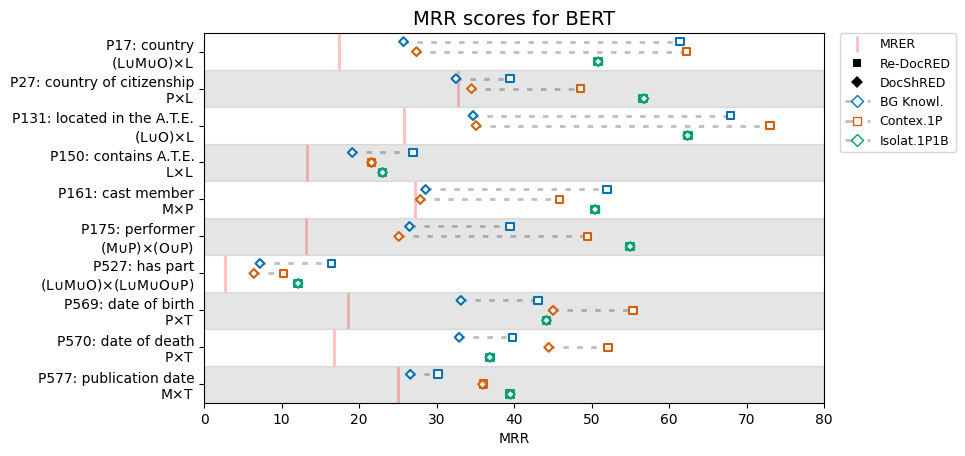

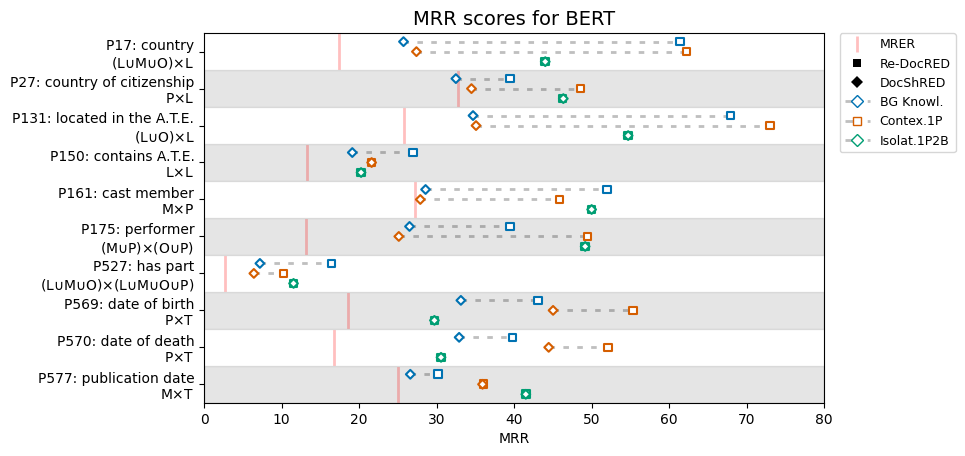

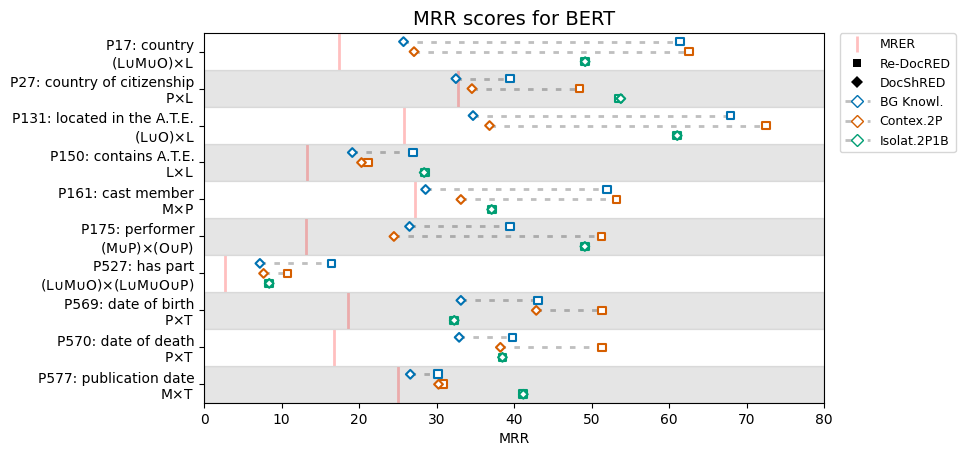

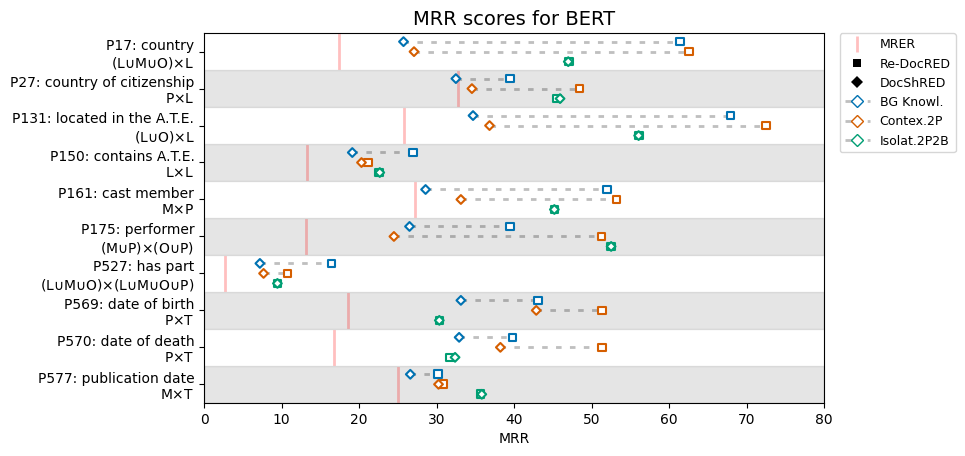

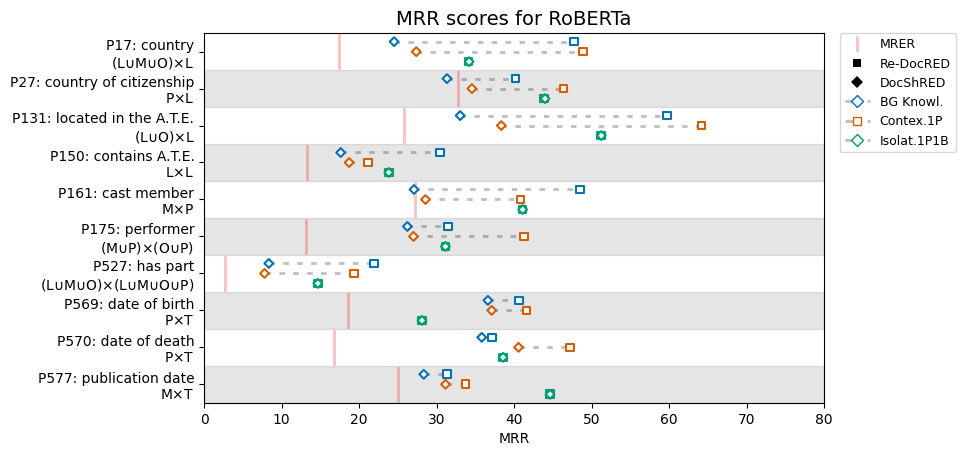

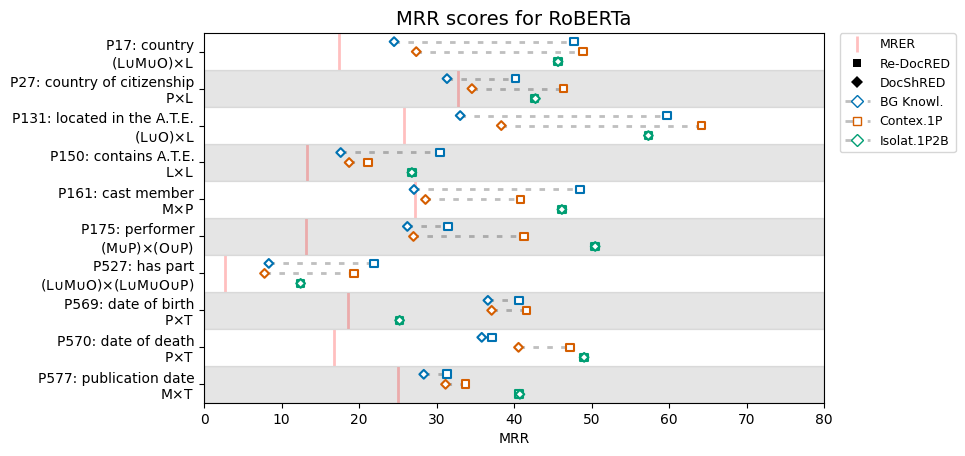

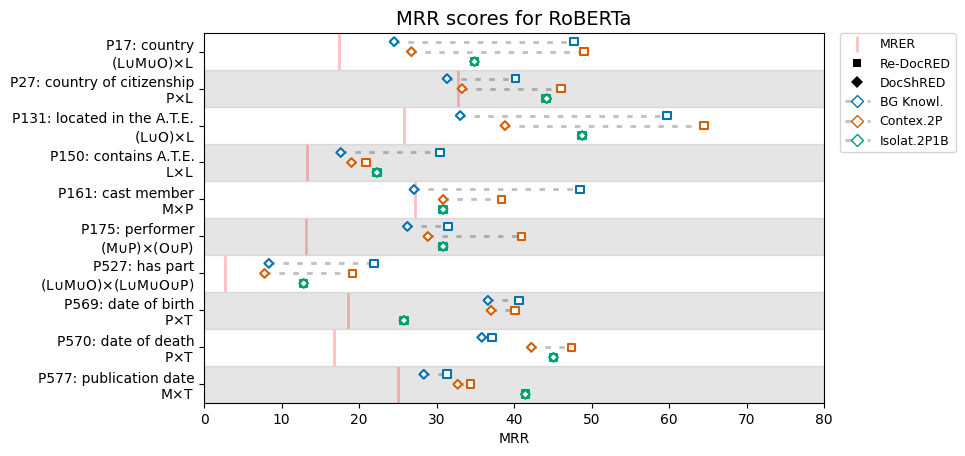

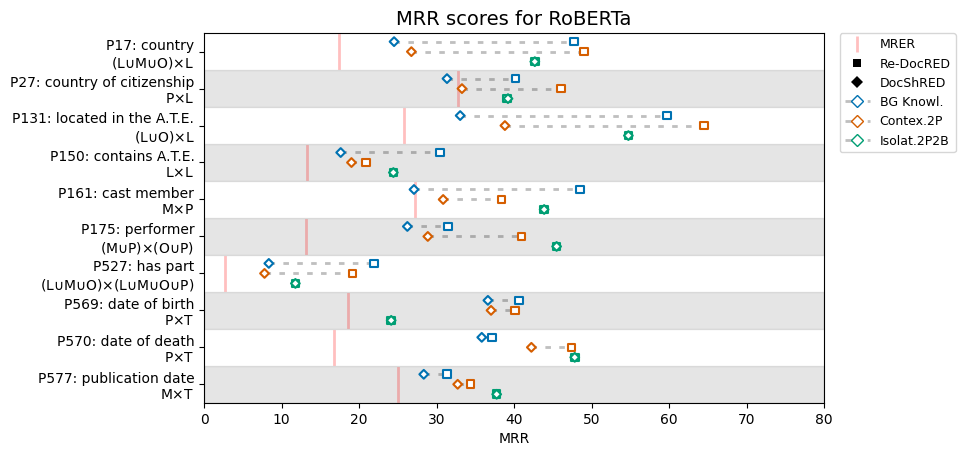

In [190]:
# Four figures per LM:
#  1 pass con, 1 blank  # <-- Shown in paper.
#  1 pass con, 2 blank
#  2 pass con, 1 blank
#  2 pass con, 2 blank

pd.set_option('display.max_rows', 500)

models = [
          "bert-large-cased",
          "roberta-large",
         ]

model_shortnames = [
    "BERT",
    "RoBERTa",
]

sym_dr = "s"
sym_ds = "D"

markers = {
    're-docshred': sym_ds,
    're-docred': sym_dr
}

marker_sizes = {
    're-docshred': 20,
    're-docred': 30
}


lgns = []

all_experiments = {
    0: f"BG Knowl.",
    1: f"Contex.1P",
    2: f"Contex.2P",
    3: f"Isolat.1P1B",
    4: f"Isolat.2P1B",
    5: f"Isolat.1P2B",
    6: f"Isolat.2P2B",
}

exp_hues = {
    0: bluish,
    1: reddish,
    2: reddish,
    3: greenish,
    4: greenish,
    5: greenish,
    6: greenish,
}

exp_hues_2 = {
    "BG Knowl.": bluish,
    "Contex.1P": reddish,
    "Contex.2P": reddish,
    "Isolat.1P1B": greenish,
    "Isolat.2P1B": greenish,
    "Isolat.1P2B": greenish,
    "Isolat.2P2B": greenish,
}

for model in models:
    for exps in [(0, 1, 3), (0, 1, 5), (0, 2, 4), (0, 2, 6)]:
        fig, ax = plt.subplots()

        experiments = {e: all_experiments[e] for e in exps}

        # m_id = 0

        # model = models[m_id]

        # experiments = {
        #     0: f"{model_shortnames[m_id]}",
        #     1: f"{model_shortnames[m_id]}+C",
        #     3: f"{model_shortnames[m_id]}+I"
        # }

        colors = []

        _task = []
        _relation = []
        _scores = []
        _model = []
        _exps = []

        for i, e in experiments.items():
            dfa:pd.DataFrame = dfs[model]['re-docred']
            dfb:pd.DataFrame = dfs[model]['re-docshred']
            data = dfa.iloc[i]
            data2 = dfb.iloc[i]
            np.stack((data.values, data2.values))

            colors.extend(exp_hues[i] for _ in data.values)

            _task.extend("re-docred" for _ in data.values)
            _task.extend("re-docshred" for _ in data2.values)

            _model.extend(model for _ in data.values)
            _model.extend(model for _ in data2.values)

            _middle = '$\\times$'
            for d in data.index:
                _left  = '$\\cup$'.join(x[0] for x in sorted(rel_info['re-docred'][d]['domain']))
                _right = '$\\cup$'.join(x[0] for x in sorted(rel_info['re-docred'][d]['range']))
                if len(rel_info['re-docred'][d]['domain']) > 1:
                    _left = f"({_left})"
                if len(rel_info['re-docred'][d]['range']) > 1:
                    _right = f"({_right})"

                _relation.append(f"{d}: {rel_info['re-docred'][d]['name']}\n{_left}{_middle}{_right}")
                # _relation.append(f"{d}: {rel_info['re-docred'][d]['name']}")
            # _relation.extend()
            for d in data2.index:
                _left  = '$\\cup$'.join(x[0] for x in sorted(rel_info['re-docred'][d]['domain']))
                _right = '$\\cup$'.join(x[0] for x in sorted(rel_info['re-docred'][d]['range']))
                if len(rel_info['re-docred'][d]['domain']) > 1:
                    _left = f"({_left})"
                if len(rel_info['re-docred'][d]['range']) > 1:
                    _right = f"({_right})"
                # _middle = '$\\times$'
                _relation.append(f"{d}: {rel_info['re-docshred'][d]['name']}\n{_left}{_middle}{_right}")
                # _relation.append(f"{d}: {rel_info['re-docshred'][d]['name']}")

            # _relation.extend(f"{d}: {rel_info['re-docshred'][d]['name']}\n{{{'$\\cup$'.join(x[0] for x in rel_info['re-docred'][d]['domain'])}}}$\\times${{{'$\\cup$'.join(x[0] for x in rel_info['re-docred'][d]['range'])}}}" for d in data2.index)

            _scores.extend(data.values)
            _scores.extend(data2.values)

            _exps.extend(e for _ in data.index)
            _exps.extend(e for _ in data2.index)

        pdx = pd.DataFrame.from_dict({"task": _task, "Relation": _relation, "MRR": _scores, "model": _model, "Experiment": _exps})

        _hue = pdx[['Relation', "Experiment"]].apply(tuple, axis=1)
        _pal = sns.color_palette(colors, 30)

        exp_hues_2 = {
            "BG Knowl.": _pal[0],
            "Contex.1P": _pal[10],
            "Contex.2P": _pal[10],
            "Isolat.1P1B": _pal[20],
            "Isolat.2P1B": _pal[20],
            "Isolat.1P2B": _pal[20],
            "Isolat.2P2B": _pal[20],
        }


        sns.lineplot(
            data=pdx, x='MRR', y='Relation', markers=False, hue=_hue, ax=ax, dashes=(2, 3), linewidth=2, palette=_grey, zorder=1
        )

        line_off = .1


        offset = transforms.ScaledTranslation(0, 0.1, ax.figure.dpi_scale_trans)
        for line in ax.lines[0:10]:
            line.set_transform(line.get_transform() + offset)
        offset = transforms.ScaledTranslation(0, -0.1, ax.figure.dpi_scale_trans)
        for line in ax.lines[20:30]:
            line.set_transform(line.get_transform() + offset)


        # plt.legend([], [], frameon=False)
        off_y_base = -0.0005

        # exps = [0, 1, 3]
        # for i, e in enumerate(reversed(exps), start=-1):
        #     offset = transforms.ScaledTranslation(0, off_y_base + .1*i, ax.figure.dpi_scale_trans)
        #     sns.scatterplot(
        #         data=pdx[(pdx['task']=='re-docshred') & (pdx["Experiment"]==experiments[e])], x='MRR', y='Relation', hue=_hue, marker=sym_ds, s=20, ax=ax, palette=_white,zorder=2
        #     )
        #     ax.collections[-1].set_transform(ax.collections[-1].get_transform() + offset)
        #     sns.scatterplot(
        #         data=pdx[(pdx['task']=='re-docred') & (pdx["Experiment"]==experiments[e])], x='MRR', y='Relation', hue=_hue, marker=sym_dr, s=20, ax=ax, palette=_white,zorder=2
        #     )
        #     ax.collections[-1].set_transform(ax.collections[-1].get_transform() + offset)
        for i, e in enumerate(reversed(exps), start=-1):
            offset = transforms.ScaledTranslation(0, off_y_base + .1*i, ax.figure.dpi_scale_trans)
            # print(p_inter['Experiment'])
            # print(p_inter["Experiment"].map(exp_hues_2))

            for ts in ['re-docred', 're-docshred']:
                p_inter = pdx[(pdx['task']==ts) & (pdx["Experiment"]==experiments[e])]
                v = exp_hues_2[p_inter["Experiment"].values[0]]
                sns.scatterplot(
                    data=p_inter, x='MRR', y='Relation', hue=_hue, marker=markers[ts], palette=_white, linewidth=1.5, s=marker_sizes[ts], ax=ax, edgecolor=v, zorder=2, 
                )
                ax.collections[-1].set_transform(ax.collections[-1].get_transform() + offset)
            # # print("Cool!")
            # p_inter = pdx[(pdx['task']=='re-docred') & (pdx["Experiment"]==experiments[e])]
            # v = exp_hues_2[p_inter["Experiment"].values[0]]
            # sns.scatterplot(
            #     data=p_inter, x='MRR', y='Relation', hue=_hue, marker=sym_dr, linewidth=2, s=50, ax=ax, palette=_pal, edgecolor=v, zorder=2
            # )
            # ax.collections[-1].set_transform(ax.collections[-1].get_transform() + offset)

        # plt.legend([],[], frameon=False)
        # print(ax.collections)
        # sns.scatterplot(
        #     data=pdx[pdx['task']=='re-docred'], x='MRR', y='Relation', hue=_hue, marker="o", s=50, ax=ax, palette=_pal
        # )
        # plt.legend([],[], frameon=False)
        # print(ax.collections)
        # for i in range(3):
        # offset = transforms.ScaledTranslation(0, .1, ax.figure.dpi_scale_trans)
        # for c in ax.collections[20:30]:
        #     trans = c.get_transform()
        #     c.set_transform(trans + offset)

        ax: plt.Axes
        for i in range(5):
            ax.axhspan(ymin=0.5 + i*2, ymax=1.5 + i*2, color=[0,0,0, 0.1])
        for i, mrer in enumerate(reversed(mrers)):
            ax.axvline(mrer, ymin=0.1*i + 0.005, ymax=0.1*i + 0.095, color=[1.0,0,0, 0.25], zorder=1, lw=2)


        # fig, ax = plt.subplots()

        # x_max = 60 if m_id != 0 else 90

        ax.set(xlim=(0, 80), ylim=(9.5, -0.5))
        ax.set_ylabel("", fontsize=0)
        # if x > 0:
        #     ax.yaxis.set_visible(False)
        #     ax.set_yticklabels([])
        # ax.set_xlabel("")
        ax.set_title(f"MRR scores for {model_names[model].split()[0]}", fontsize=14)
        ax.get_legend().remove()
        # lgn = plt.legend()
        # lgns.append(lgn)
        # if x == 0:
            # plt.gca().add_artist(lgn)

        width = 347.12354 // 72.27

        factor = 8.0 / 6.4

        custom_lines = [
            mpl.lines.Line2D([], [], color=[1.0,0,0, 0.25], marker='|', linestyle='None', linewidth=0, markeredgecolor=[1.0,0,0,0.25], markeredgewidth=2, markersize=12),
        ]
        custom_lines += [
            mpl.lines.Line2D([0], [0], color="w", marker=sym_dr, label='Scatter', linewidth=0, markerfacecolor='black', markeredgewidth=0.0, markersize=6),
            mpl.lines.Line2D([0], [0], color="w", marker=sym_ds, label='Scatter', linewidth=0, markerfacecolor='black', markeredgewidth=0.0, markersize=6),
        ]
        custom_lines += [
            mpl.lines.Line2D([0, 1], [0, 0], color=(0.75, 0.75, 0.75), marker='s' if m == 1 else 'D', label='Scatter', markeredgewidth=1, markerfacecolor='white', markeredgecolor=exp_hues[m], dashes=[4], lw=2, markersize=6)
            for m in exps
        ]
        # print(exps)
        custom_labels = ['MRER'] + ['Re-DocRED', 'DocShRED'] + [experiments[m] for m in exps]
        # custom_lines[1], custom_lines[2], custom_lines[5], custom_lines[4], custom_lines[3] = custom_lines[5], custom_lines[1], custom_lines[4], custom_lines[2], custom_lines[3]
        # custom_labels[1], custom_labels[2], custom_labels[5], custom_labels[4], custom_labels[3] = custom_labels[5], custom_labels[1], custom_labels[4], custom_labels[2], custom_labels[3]
        # plt.legend(custom_lines, custom_labels, bbox_to_anchor=(-1.075, -0.275, 2.075, 0.2), loc="upper left", mode="expand", borderaxespad=0, ncol=1, prop={'size':9})
        plt.legend(custom_lines, custom_labels, bbox_to_anchor=(1.025, 1.0, 0, 0), loc="upper left", borderaxespad=0, ncol=1, prop={'size':9})

        fig = mpl.pyplot.gcf()
        print(fig.get_size_inches(), width)
        # fig.set_size_inches(18.5, 10.5)
        fig.set_size_inches(8.0, 4.8, forward=True)
        plt.subplots_adjust(wspace=0.075, hspace=0)
        plt.savefig(f"fig2_redocred_{model}_{exps}.svg", bbox_inches='tight')
